In [10]:
import tensorflow as tf
import pandas as pd
import numpy as np

import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pacifier\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
from keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [11]:
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification

c:\Users\Pacifier\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Using a smaller version of the dataset from tensdorflow_datasets because of time constraint

In [25]:
import tensorflow_datasets as tfds
amazon_ds = tfds.load('amazon_us_reviews/Mobile_Electronics_v1_00', split='train', shuffle_files=True)
assert isinstance(amazon_ds, tf.data.Dataset)
print(amazon_ds)

<PrefetchDataset element_spec={'data': {'customer_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'helpful_votes': TensorSpec(shape=(), dtype=tf.int32, name=None), 'marketplace': TensorSpec(shape=(), dtype=tf.string, name=None), 'product_category': TensorSpec(shape=(), dtype=tf.string, name=None), 'product_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'product_parent': TensorSpec(shape=(), dtype=tf.string, name=None), 'product_title': TensorSpec(shape=(), dtype=tf.string, name=None), 'review_body': TensorSpec(shape=(), dtype=tf.string, name=None), 'review_date': TensorSpec(shape=(), dtype=tf.string, name=None), 'review_headline': TensorSpec(shape=(), dtype=tf.string, name=None), 'review_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'star_rating': TensorSpec(shape=(), dtype=tf.int32, name=None), 'total_votes': TensorSpec(shape=(), dtype=tf.int32, name=None), 'verified_purchase': TensorSpec(shape=(), dtype=tf.int64, name=None), 'vine': TensorSpec(shape=(), dtype=

In [28]:
df = tfds.as_dataframe(amazon_ds)
df.head()

,data/customer_id,data/helpful_votes,data/marketplace,data/product_category,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_date,data/review_headline,data/review_id,data/star_rating,data/total_votes,data/verified_purchase,data/vine
0,b'20980074',0,b'US',b'Mobile_Electronics',b'B00D1847NE',b'274617424',b'Teenage Mutant Ninja Turtles Boombox CD Play...,b'Does not work',b'2015-01-09',b'One Star',b'R1OVS0D6SEXPW7',1,0,0,1
1,b'779273',0,b'US',b'Mobile_Electronics',b'B00KMO6DYG',b'397452138',b'4 Gauge Amp Kit Amplifier Install Wiring Com...,b'This is a great wiring kit i used it to set ...,b'2015-08-06',b'Great kit',b'R9VSD0ET8FERB',4,0,0,1
2,b'15410531',0,b'US',b'Mobile_Electronics',b'B000GWLL0K',b'948304826',b'Travel Wall Charger fits Creative Zen Vision...,b'It works great so much faster than USB charg...,b'2007-03-15',b'A/C Charger for Creative Zen Vision M',b'R3ISXCZHWLJLBH',5,0,0,1
3,b'27389005',0,b'US',b'Mobile_Electronics',b'B008L3JE6Y',b'466340015',b'High Grade Robust 360\xc2\xb0 Adjustable Car...,b'This product was purchased to hold a monitor...,b'2013-07-30',b'camera stand',b'R1TWVUDOFJSQAW',5,0,0,1
4,b'2663569',0,b'US',b'Mobile_Electronics',b'B00GHZS4SC',b'350592810',b'HDE Multifunctional Bluetooth FM Audio Car K...,"b""it works but it has really bad sound quality...",b'2014-12-31',b'bad sound quality',b'R2PEOEUR1LP0GH',3,0,0,1


In [29]:
df["Sentiment"] = df["data/star_rating"].apply(lambda score: "positive" if score >= 3 else "negative")
df['Sentiment'] = df['Sentiment'].map({'positive':1, 'negative':0})

In [30]:
df['short_review'] =df['data/review_body'].str.decode("utf-8")

In [31]:
df = df[["short_review", "Sentiment"]]

In [33]:
index = df.index
number_of_rows = len(index)
print(number_of_rows)

104975


In [34]:
df.tail()

,short_review,Sentiment
104970,It's a wonderful invention. You don't need to ...,1
104971,"This is not good item,I can even maket work,th...",0
104972,The cover and skin were both exactly like the ...,1
104973,I ordered 2 of these cords for both mine and m...,0
104974,Item works better than I had hoped for. Very c...,1


In [35]:

reviews = df['short_review'].values.tolist()
labels = df['Sentiment'].tolist()

In [36]:

print(reviews[:2])
print(labels[:2])

['Does not work', 'This is a great wiring kit i used it to set up my Pyle 2000 watt amp to 2 alpine subs and worked just fine. im not sure about the power cord and its length because my battery is in the back but the ground cord is a bit short and thats its only flaw and that why i gave it 4 stars. great kit']
[0, 1]


In [38]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.20, random_state=42)


### Preparing Embedded Layer

In [39]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [40]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Using GloVe Embeddings to create feature matrix

In [42]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

Creating an embedding matrix where each row number will correspond to the index of the word in the corpus. 

In [43]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Creating a CNN Model

In [48]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

### Layers of the model

In [49]:
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          5350700   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 5,414,957
Trainable params: 64,257
Non-trainable params: 5,350,700
_________________________________________________________________
None


In [53]:
y_train = np.array(y_train)
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
525/525 [==============================] - 75s 132ms/step - loss: 0.3464 - acc: 0.8451 - val_loss: 0.2744 - val_acc: 0.8818
Epoch 2/6
525/525 [==============================] - 74s 141ms/step - loss: 0.2509 - acc: 0.8946 - val_loss: 0.2565 - val_acc: 0.8887
Epoch 3/6
525/525 [==============================] - 64s 121ms/step - loss: 0.2186 - acc: 0.9091 - val_loss: 0.2489 - val_acc: 0.8938
Epoch 4/6
525/525 [==============================] - 59s 112ms/step - loss: 0.1872 - acc: 0.9254 - val_loss: 0.2495 - val_acc: 0.8957
Epoch 5/6
525/525 [==============================] - 63s 120ms/step - loss: 0.1636 - acc: 0.9356 - val_loss: 0.2482 - val_acc: 0.8953
Epoch 6/6
525/525 [==============================] - 72s 137ms/step - loss: 0.1455 - acc: 0.9450 - val_loss: 0.2522 - val_acc: 0.8960


In [56]:
y_test = np.array(y_test)
score = model.evaluate(X_test, y_test, verbose=1)

657/657 [==============================] - 15s 22ms/step - loss: 0.2566 - acc: 0.8948


In [57]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.25656935572624207
Test Accuracy: 0.8947844505310059


### Plotting for loss and accuracy difference between the training and test set

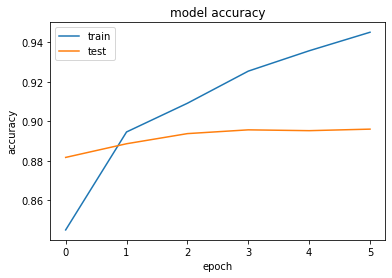

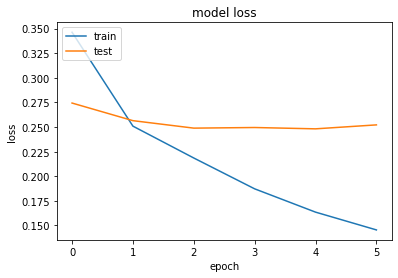

In [60]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

Test accuracies are much lower than the train accuracies. 
Hence, to resolve this epochs can be increased up until the convergence point

### Using LSTM to improve Accuracy

In [63]:
from tensorflow.keras.layers import LSTM

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [64]:
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          5350700   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5,468,077
Trainable params: 117,377
Non-trainable params: 5,350,700
_________________________________________________________________
None


In [65]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
525/525 [==============================] - 299s 550ms/step - loss: 0.5478 - acc: 0.7617 - val_loss: 0.5425 - val_acc: 0.7595
Epoch 2/6
525/525 [==============================] - 300s 572ms/step - loss: 0.5443 - acc: 0.7625 - val_loss: 0.5461 - val_acc: 0.7607
Epoch 3/6
525/525 [==============================] - 285s 542ms/step - loss: 0.5405 - acc: 0.7624 - val_loss: 0.5467 - val_acc: 0.7629
Epoch 4/6
525/525 [==============================] - 261s 498ms/step - loss: 0.3948 - acc: 0.8228 - val_loss: 0.3128 - val_acc: 0.8643
Epoch 5/6
525/525 [==============================] - 256s 488ms/step - loss: 0.2931 - acc: 0.8724 - val_loss: 0.2813 - val_acc: 0.8785
Epoch 6/6
657/657 [==============================] - 61589s 94s/step - loss: 0.2726 - acc: 0.8884


In [66]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.2725878953933716
Test Accuracy: 0.888401985168457


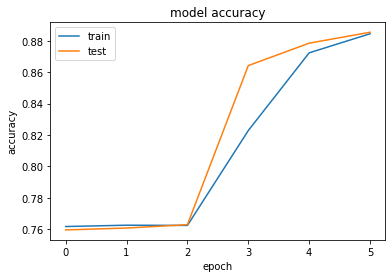

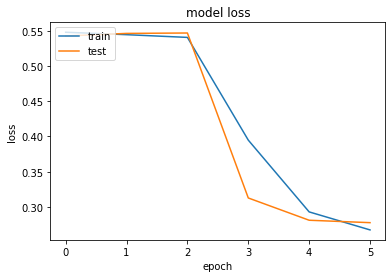

In [67]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()